# Importação das Bibliotecas

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import shapiro
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Importação Dos Dados

In [ ]:
df = pd.read_csv('/content/usmelec.csv')
df["Data"] = pd.to_datetime(df["Data"])
df = df.set_index('Data')
df.head(5)

,Valor
Data,
1973-01-01,160.218
1973-02-01,143.539
1973-03-01,148.158
1973-04-01,139.589
1973-05-01,147.395


# Visualização e Exploração de Dados

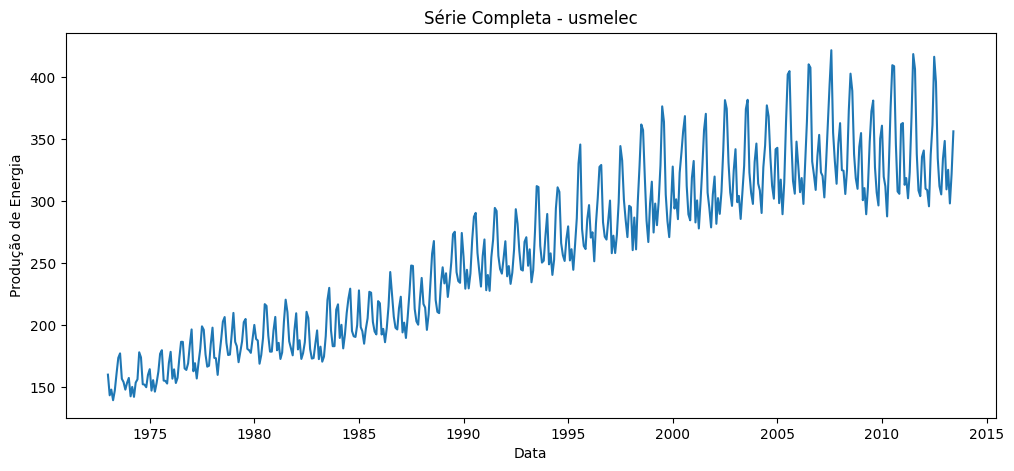

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(df['Valor'])
plt.title("Série Completa - usmelec")
plt.xlabel("Data")
plt.ylabel("Produção de Energia")
plt.show()

 Podemos ver que a série apresenta uma tendência crescente, aparentemente linerar, e uma sazonalidade que aparentemente é anual.

## Decomposição da Série

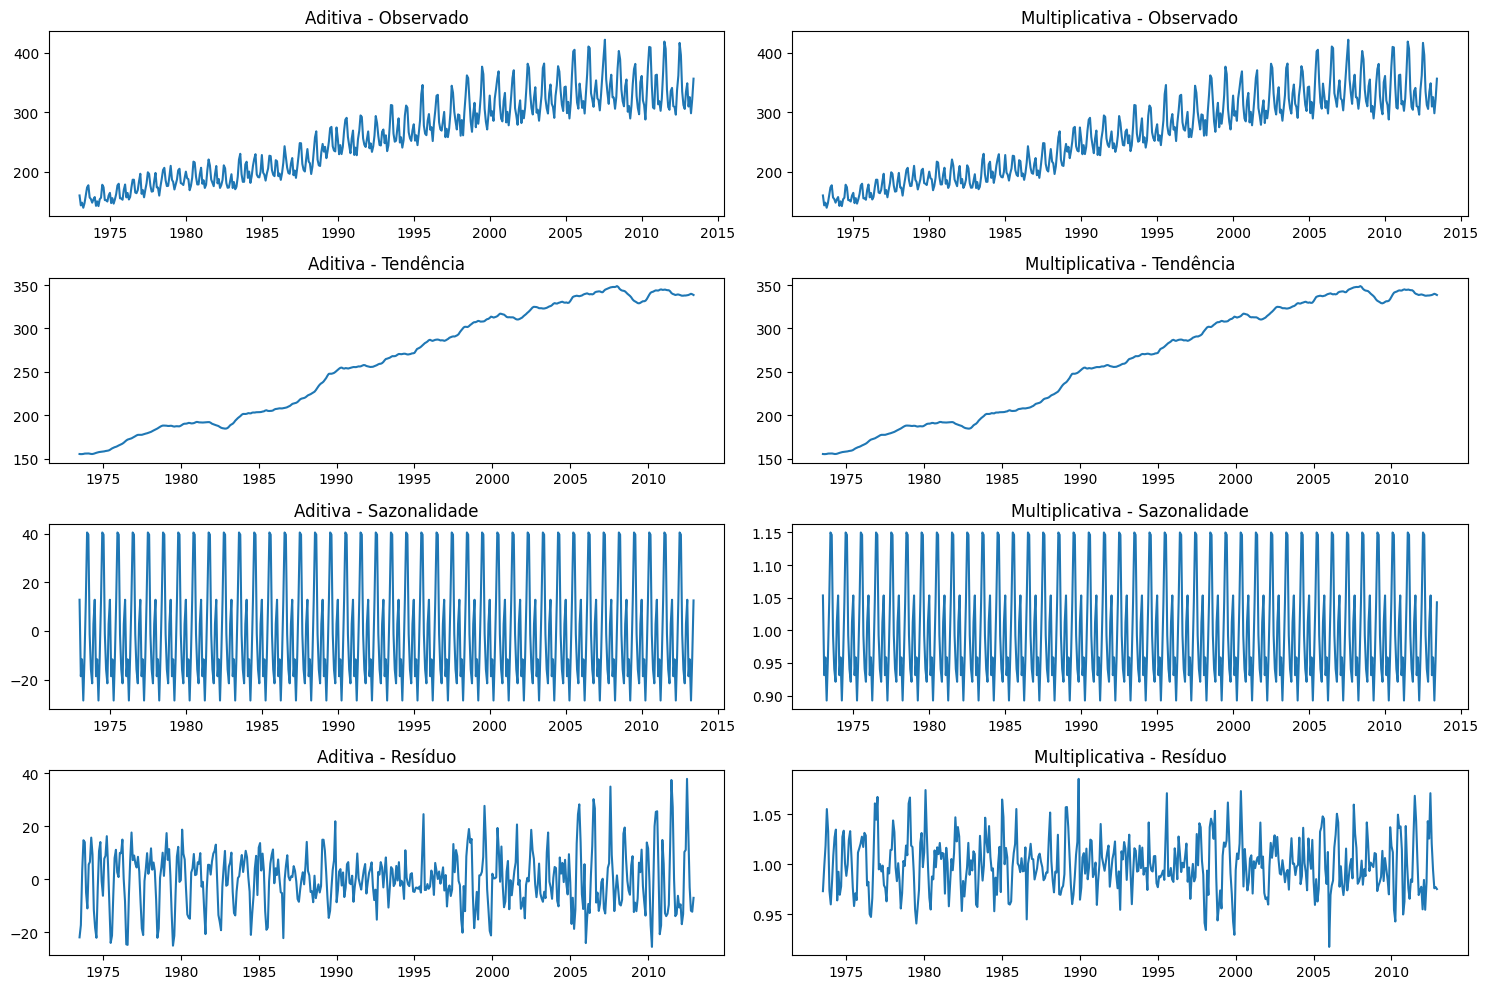

Variância do Resíduo (Aditiva): 111.68133718164474
Variância do Resíduo (Multiplicativa): 0.0007195915116147831


In [ ]:
serie = df['Valor']
decomp_add = seasonal_decompose(serie, model='additive', period=12)

# --- Decomposição clássica multiplicativa ---
decomp_mul = seasonal_decompose(serie, model='multiplicative', period=12)

# --- Plot lado a lado ---
fig, ax = plt.subplots(4, 2, figsize=(15, 10))

# ---- Aditiva ----
ax[0,0].plot(decomp_add.observed)
ax[0,0].set_title("Aditiva - Observado")

ax[1,0].plot(decomp_add.trend)
ax[1,0].set_title("Aditiva - Tendência")

ax[2,0].plot(decomp_add.seasonal)
ax[2,0].set_title("Aditiva - Sazonalidade")

ax[3,0].plot(decomp_add.resid)
ax[3,0].set_title("Aditiva - Resíduo")

# ---- Multiplicativa ----
ax[0,1].plot(decomp_mul.observed)
ax[0,1].set_title("Multiplicativa - Observado")

ax[1,1].plot(decomp_mul.trend)
ax[1,1].set_title("Multiplicativa - Tendência")

ax[2,1].plot(decomp_mul.seasonal)
ax[2,1].set_title("Multiplicativa - Sazonalidade")

ax[3,1].plot(decomp_mul.resid)
ax[3,1].set_title("Multiplicativa - Resíduo")

plt.tight_layout()
plt.show()

# --- Comparação de resíduos ---
var_add = np.nanvar(decomp_add.resid)
var_mul = np.nanvar(decomp_mul.resid)

print("Variância do Resíduo (Aditiva):", var_add)
print("Variância do Resíduo (Multiplicativa):", var_mul)


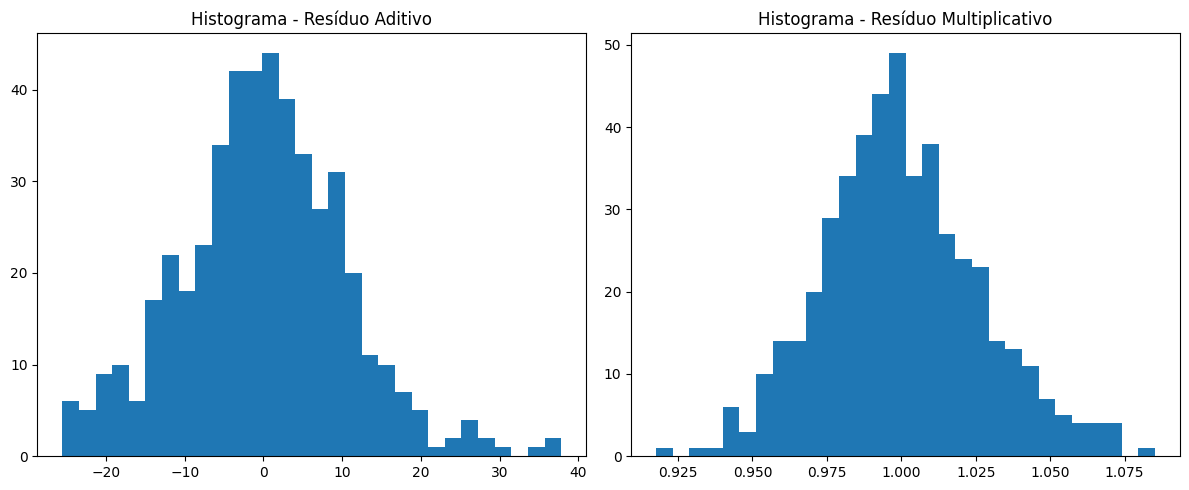

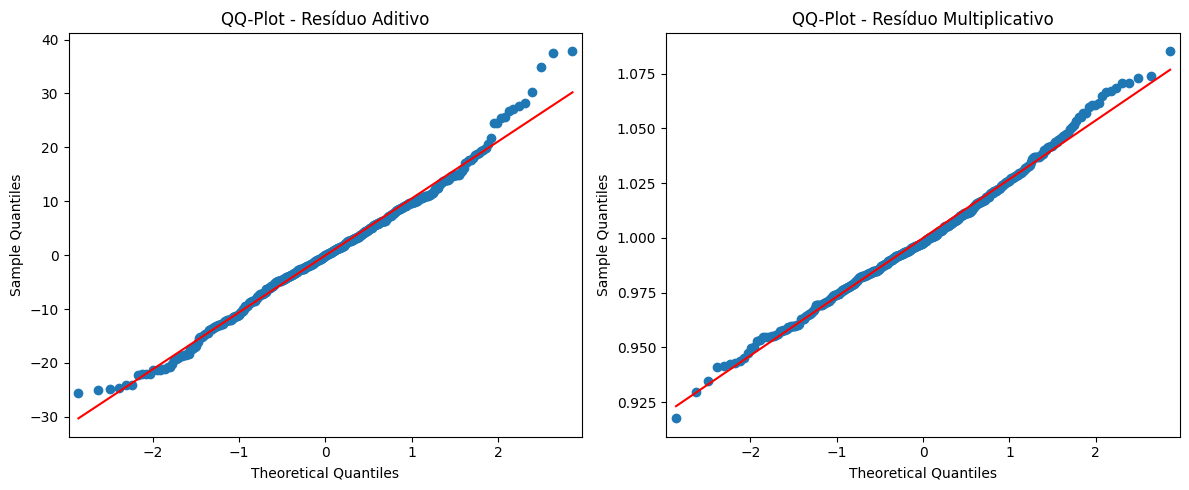


====== SHAPIRO-WILK ======

Aditivo:
  Estatística: 0.9895
  p-valor:      0.0018
  >> Rejeita normalidade (não parece normal)

Multiplicativo:
  Estatística: 0.9941
  p-valor:      0.0614
  >> Não rejeita normalidade (parece normal)


In [ ]:
res_add = decomp_add.resid.dropna()
res_mul = decomp_mul.resid.dropna()
sh_add = shapiro(res_add)
sh_mul = shapiro(res_mul)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].hist(res_add, bins=30)
ax[0].set_title("Histograma - Resíduo Aditivo")

ax[1].hist(res_mul, bins=30)
ax[1].set_title("Histograma - Resíduo Multiplicativo")

plt.tight_layout()
plt.show()

# -------------------------
# QQ-PLOTS (opcional mas recomendado)
# -------------------------

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sm.qqplot(res_add, line="s", ax=ax[0])
ax[0].set_title("QQ-Plot - Resíduo Aditivo")

sm.qqplot(res_mul, line="s", ax=ax[1])
ax[1].set_title("QQ-Plot - Resíduo Multiplicativo")

plt.tight_layout()
plt.show()

# -------------------------
# TESTE DE NORMALIDADE (Shapiro-Wilk)
# -------------------------

sh_add = shapiro(res_add)
sh_mul = shapiro(res_mul)

print("\n====== SHAPIRO-WILK ======\n")
print("Aditivo:")
print(f"  Estatística: {sh_add.statistic:.4f}")
print(f"  p-valor:      {sh_add.pvalue:.4f}")
if sh_add.pvalue > 0.05:
    print("  >> Não rejeita normalidade (parece normal)")
else:
    print("  >> Rejeita normalidade (não parece normal)")

print("\nMultiplicativo:")
print(f"  Estatística: {sh_mul.statistic:.4f}")
print(f"  p-valor:      {sh_mul.pvalue:.4f}")
if sh_mul.pvalue > 0.05:
    print("  >> Não rejeita normalidade (parece normal)")
else:
    print("  >> Rejeita normalidade (não parece normal)")

Dados os resultados obtidos, observa-se que a decomposição multiplicativa apresenta desempenho significativamente superior à decomposição aditiva. A variância do resíduo no modelo multiplicativo é muito menor, indicando que a tendência e a sazonalidade foram extraídas de forma mais eficaz. Além disso, os resíduos resultantes dessa decomposição não rejeitam a hipótese de normalidade no teste de Shapiro–Wilk, evidenciando um comportamento estatisticamente mais adequado. Assim, conclui-se que a decomposição clássica multiplicativa é a mais apropriada para representar a série usmelec.

## Análise de Sazonalidade

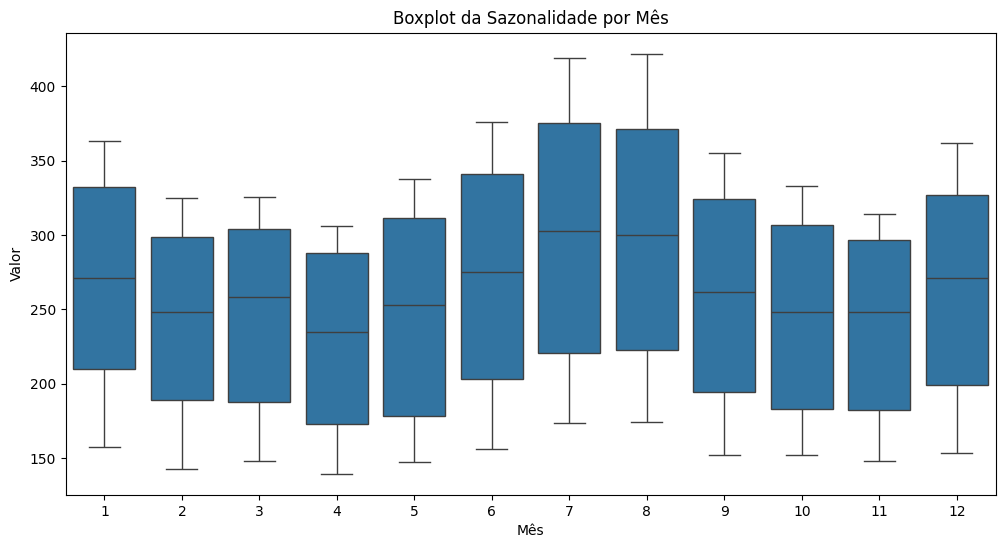

In [ ]:
# Criar tabela ano × mês
tmp = serie.to_frame('Valor')
tmp['Ano'] = tmp.index.year
tmp['Mes'] = tmp.index.month

plt.figure(figsize=(12,6))
sns.boxplot(x=tmp['Mes'], y=tmp['Valor'])
plt.title("Boxplot da Sazonalidade por Mês")
plt.xlabel("Mês")
plt.ylabel("Valor")
plt.show()

A série apresenta um padrão sazonal claro: o consumo de energia cresce nos meses mais quentes, com picos em julho e agosto devido ao uso intenso de ar-condicionado. No inverno, há um aumento moderado ligado ao aquecimento, embora menor que no verão. Já os meses de transição, outono e primavera, tendem a registrar os menores níveis de consumo, refletindo temperaturas mais amenas e menor necessidade de climatização.

## Análise de Correlação

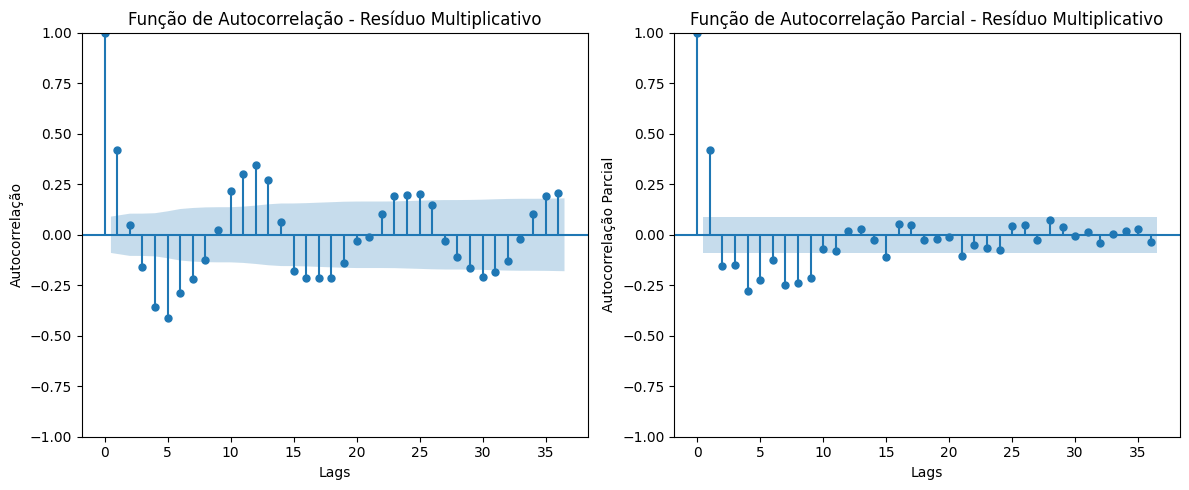

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# ACF Plot
plot_acf(res_mul, lags=36, ax=ax[0])
ax[0].set_title('Função de Autocorrelação - Resíduo Multiplicativo')
ax[0].set_xlabel('Lags')
ax[0].set_ylabel('Autocorrelação')

# PACF Plot
plot_pacf(res_mul, lags=36, ax=ax[1])
ax[1].set_title('Função de Autocorrelação Parcial - Resíduo Multiplicativo')
ax[1].set_xlabel('Lags')
ax[1].set_ylabel('Autocorrelação Parcial')

plt.tight_layout()
plt.show()

Embora a decomposição multiplicativa tenha reduzido significativamente a variância dos resíduos e melhorado a normalidade, tanto os gráficos de Função de Autocorrelação (ACF) quanto Função de Autocorrelação Parcial (PACF) indicam que ainda existem padrões de autocorrelação significativos.

Particularmente, observamos picos importantes em lags sazonais (especialmente em torno de 12 meses), o que sugere que parte da sazonalidade pode não ter sido completamente capturada pela decomposição inicial ou que existem outras dependências sazonais remanescentes. Além disso, a presença de autocorrelação em lags de curto prazo (1 e 2 meses) indica que os valores residuais atuais ainda são previsíveis com base nos valores residuais imediatamente anteriores.

Este cenário nos leva à conclusão de que os resíduos não são ruído branco puro, ou seja, eles ainda contêm informação estrutural que pode ser modelada. Isso implica que um modelo mais robusto, como um modelo SARIMA, devido à sazonalidade residual, seria mais apropriado para capturar essas dependências remanescentes e melhorar a precisão das previsões futuras.

# Modelos

# Separação entre treino e teste

In [ ]:
# tamanho do conjunto de teste
n_test = 12

# separação
train = df.iloc[:-n_test].copy()
test  = df.iloc[-n_test:].copy()

train.shape, test.shape


((474, 1), (12, 1))

# Holt Winters

### Modelagem

In [ ]:
hw_model = ExponentialSmoothing(
    train,                     # série de treino
    trend='add',               # tendência aditiva (mais comum p/ esse tipo de dado)
    seasonal='mul',            # sazonalidade multiplicativa
    seasonal_periods=12        # periodicidade de 12 meses
).fit()


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


### Analise de Significância

In [ ]:
hw_model.params


{'smoothing_level': np.float64(0.30657560523286975),
 'smoothing_trend': np.float64(0.0),
 'smoothing_seasonal': np.float64(0.2136906558529457),
 'damping_trend': nan,
 'initial_level': np.float64(155.19815139903585),
 'initial_trend': np.float64(0.4583783209262603),
 'initial_seasons': array([1.0409537 , 0.9178456 , 0.94165184, 0.87483126, 0.92267567,
        0.98406219, 1.07477425, 1.07224968, 0.94261047, 0.92467901,
        0.92169061, 0.99660704]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

### Previsão

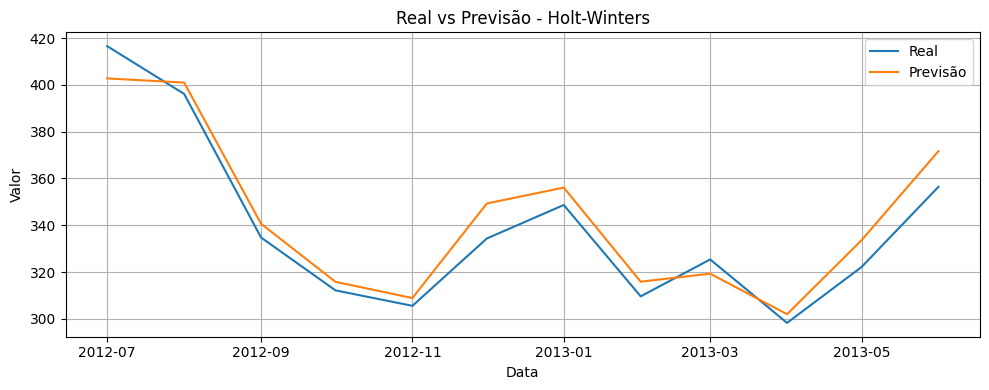

In [ ]:
y_pred = hw_model.forecast(len(test))

# plot
plt.figure(figsize=(10,4))
plt.plot(test.index, test.values, label='Real')
plt.plot(test.index, y_pred.values, label='Previsão')
plt.title('Real vs Previsão - Holt-Winters')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
test = test.squeeze()
y_pred = y_pred.squeeze()

mse  = mean_squared_error(test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(test, y_pred)
mape = np.mean(np.abs((test - y_pred) / test)) * 100

print("MSE :", mse)
print("RMSE:", rmse)
print("MAE :", mae)
print("MAPE:", mape)

MSE : 83.70270002927626
RMSE: 9.148917970409192
MAE : 8.051238989977406
MAPE: 2.34318532799903


## SARIMA

In [ ]:
comparacao = pd.read_csv('/content/comparacao.csv', sep = ';')

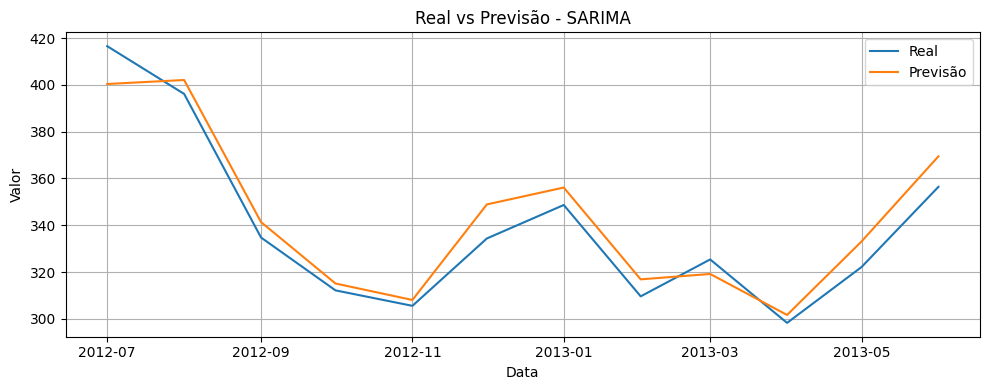

In [ ]:
# plot
plt.figure(figsize=(10,4))
plt.plot(test.index, comparacao.Real, label='Real')
plt.plot(test.index, comparacao.Previsto, label='Previsão')
plt.title('Real vs Previsão - SARIMA')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()